In [1]:
import os
import tensorflow as tf
import numpy as np
import zipfile
import random
import collections
import pickle

In [2]:
def grammar(length):
    mygrammar = [1, 0, 2]
    if length <= 0:
        raise ValueError('Length should be >= 1') 
    if length == 1:
        return [0]
    if length == 2:
        return [1,0]
    for i in range(3,length):
        if length % 3 == 1 and i == length - 1:
            next_pos = length - 1
        else:
            next_pos = mygrammar[i-3] + 3
        mygrammar.append(next_pos)
    return mygrammar

print(grammar(1))
print(grammar(2))
print(grammar(10))
print(grammar(11))

[0]
[1, 0]
[1, 0, 2, 4, 3, 5, 7, 6, 8, 9]
[1, 0, 2, 4, 3, 5, 7, 6, 8, 10, 9]


In [3]:
def encode(text):
    """ Numberize a sequence """
    words = text.split()
    new_text = ''
    for i in grammar(len(words)):
        new_text += str(len(words[i]))
    return new_text

test = 'neural machine translation'
print(test)
print(encode(test))

neural machine translation
7611


In [4]:
with open('dicts/dictionary.pickle', 'rb') as handle:
  dictionary = pickle.load(handle)
with open('dicts/reverse_dictionary.pickle', 'rb') as handle:
  reverse_dictionary = pickle.load(handle)

In [113]:
def word2id(word):
    return dictionary.get(word, 0)
  
def id2num(num_id):
  if num_id < 10:
    return str(num_id)
  if num_id == PAD_ID:
    return 'P'
  if num_id == GO_ID:
    return 'G'
  if num_id == EOS_ID:
    return 'E'

def gen_text(predictions):
  text = ''
  for onehot in predictions:
    num = id2num(np.argmax(onehot[0]))
    if num != 'E':
      text += num
    else:
      return text
  return text

print(word2id('life'))

130


In [71]:
class BatchGenerator(object):
  def __init__(self, text, batch_size, global_id = 0, length = None):
    self._words = text.split()
    self._text_size = len(text)
    self._batch_size = batch_size
    self._global_id = global_id
    self._length = length
  
  def next(self):
    input_sequences = list()
    encoder_inputs = list()
    decoder_inputs = list()
    labels = list()
    weights = list()

    for i in range(self._batch_size):
      if self._length == None:
        length = random.randint(1,MAX_INPUT_SEQUENCE_LENGTH)
      else:
        length = self._length
      input_words = self._words[self._global_id:self._global_id+length]
      input_word_ids = [word2id(word) for word in input_words]
      
      # reverse list and add padding
      reverse_input_word_ids = [0]*(MAX_INPUT_SEQUENCE_LENGTH-len(input_word_ids)) + input_word_ids[::-1]
      input_sequence = ' '.join(input_words)
      label_sequence = encode(input_sequence)
      label_word_ids = [int(num) for num in label_sequence]
      weight = [1.0]*len(label_word_ids)

      # append to lists
      input_sequences.append(input_sequence)
      encoder_inputs.append(reverse_input_word_ids)
      decoder_inputs.append([GO_ID] + label_word_ids + [PAD_ID]*(MAX_OUTPUT_SEQUENCE_LENGTH-len(label_word_ids)))
      labels.append(label_word_ids + [EOS_ID] + [PAD_ID]*(MAX_OUTPUT_SEQUENCE_LENGTH-len(label_word_ids)))
      weights.append(weight + [1.0] + [0.0]*((MAX_OUTPUT_SEQUENCE_LENGTH-len(weight))))

      # Update global_id
      new_global_id = self._global_id + length
      if new_global_id > len(self._words) - self._batch_size*MAX_INPUT_SEQUENCE_LENGTH:
        self._global_id = 0
      else:
        self._global_id = new_global_id

    return input_sequences, np.array(encoder_inputs).T, np.array(decoder_inputs).T, np.array(labels).T, np.array(weights).T

In [72]:
sample_text = 'i have a pen i have a apple oh apple pen i have a pen i have a pineapple oh pineapple pen apple pen pineapple pen'
sample_batches = BatchGenerator(sample_text, 2, length=4)
sample_sequences, sample_encoder_inputs, sample_decoder_inputs, sample_labels, sample_weights = sample_batches.next()

print('sequences {}'.format(sample_sequences))
print('encoder_inputs {}'.format(sample_encoder_inputs.tolist()))
print('decoder_inputs {}'.format(sample_decoder_inputs.tolist()))
print('labels {}'.format(sample_labels.tolist()))
print('weights {}'.format(sample_weights.tolist()))

sequences ['i have a pen', 'i have a apple']
encoder_inputs [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [5576, 1221], [7, 7], [40, 40], [73, 73]]
decoder_inputs [[11, 11], [4, 4], [1, 1], [1, 1], [3, 5], [10, 10], [10, 10], [10, 10], [10, 10], [10, 10], [10, 10], [10, 10], [10, 10], [10, 10], [10, 10], [10, 10], [10, 10], [10, 10], [10, 10], [10, 10], [10, 10]]
labels [[4, 4], [1, 1], [1, 1], [3, 5], [12, 12], [10, 10], [10, 10], [10, 10], [10, 10], [10, 10], [10, 10], [10, 10], [10, 10], [10, 10], [10, 10], [10, 10], [10, 10], [10, 10], [10, 10], [10, 10], [10, 10]]
weights [[1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]]


In [6]:
MAX_INPUT_SEQUENCE_LENGTH = 10
MAX_OUTPUT_SEQUENCE_LENGTH = 20
PAD_ID = 10
GO_ID = 11
EOS_ID = 12
vocabulary_size = 50000
lstm_size = 256

In [112]:
def construct_graph(use_attention=True):
  encoder_inputs = list()
  decoder_inputs = list()
  labels = list()
  weights = list() 

  for _ in range(MAX_INPUT_SEQUENCE_LENGTH):
    encoder_inputs.append(tf.placeholder(tf.int32, shape=(None,)))
  for _ in range(MAX_OUTPUT_SEQUENCE_LENGTH+1):
    decoder_inputs.append(tf.placeholder(tf.int32, shape=(None,)))
    labels.append(tf.placeholder(tf.int32, shape=(None,)))
    weights.append(tf.placeholder(tf.float32, shape=(None,)))

  feed_previous = tf.placeholder(tf.bool)
  learning_rate = tf.placeholder(tf.float32)

    # Use LSTM cell
  cell = tf.nn.rnn_cell.BasicLSTMCell(lstm_size)
  with tf.variable_scope("seq2seq"):
    if use_attention:
      outputs, states = tf.nn.seq2seq.embedding_attention_seq2seq(encoder_inputs,
                                                          decoder_inputs,
                                                          cell,
                                                          vocabulary_size, # num_encoder_symbols
                                                          13, # num_decoder_symbols
                                                          128, # embedding_size
                                                          feed_previous=feed_previous # False during training, True during testing
                                                          )
    else: 
      outputs, states = tf.nn.seq2seq.embedding_rnn_seq2seq(encoder_inputs,
                                                          decoder_inputs,
                                                          cell,
                                                          vocabulary_size, # num_encoder_symbols
                                                          13, # num_decoder_symbols
                                                          128, # embedding_size
                                                          feed_previous=feed_previous # False during training, True during testing
                                                         )
  predictions = tf.pack([tf.nn.softmax(output) for output in outputs])
  loss = tf.nn.seq2seq.sequence_loss(outputs, labels, weights) 

  tf.scalar_summary('learning rate', learning_rate)
  tf.scalar_summary('loss', loss)
  merged = tf.merge_all_summaries()

  return encoder_inputs, decoder_inputs, labels, weights, learning_rate, feed_previous, outputs, states, loss, predictions, merged

# Simple Seq2seq

In [115]:
graph = tf.Graph()
with graph.as_default():
  encoder_inputs, decoder_inputs, labels, weights, learning_rate, feed_previous, outputs, states, loss, predictions, merged = construct_graph(use_attention=False)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
  saver.restore(sess, "checkpoints/20161122_model-no-attention-500000steps.ckpt")
   
  test_feed_dict = dict()
  test_batches = BatchGenerator('neural machine translation by jointly learning to align and translate', 1, length=10)
  current_test_sequences, current_test_encoder_inputs, current_test_decoder_inputs, current_test_labels, current_test_weights = test_batches.next()
  
  test_feed_dict = {encoder_inputs[i]: current_test_encoder_inputs[i] for i in range(MAX_INPUT_SEQUENCE_LENGTH)}
  
  # feed dummy data
  test_feed_dict.update({decoder_inputs[i]: [0] for i in range(MAX_OUTPUT_SEQUENCE_LENGTH+1)})
  test_feed_dict.update({labels[i]: [0] for i in range(MAX_OUTPUT_SEQUENCE_LENGTH+1)})
  test_feed_dict.update({weights[i]: [0.0] for i in range(MAX_OUTPUT_SEQUENCE_LENGTH+1)})
  test_feed_dict.update({feed_previous: True})
  test_feed_dict.update({learning_rate: 0.1})
  
  # calculate predictions
  current_test_predictions = predictions.eval(feed_dict=test_feed_dict)

  print('Test set:')
  print('  Input            : ', current_test_sequences[0])
  print('  Correct output   : ', ''.join([id2num(n) for n in current_test_labels.T[0]]))
  print('  Generated output : ', gen_text(current_test_predictions))

Test set:
  Input            :  neural machine translation by jointly learning to align and translate
  Correct output   :  76117285239EPPPPPPPPP
  Generated output :  126112853298


# Attention Seq2seq

In [111]:
graph = tf.Graph()
with graph.as_default():
  encoder_inputs, decoder_inputs, labels, weights, learning_rate, feed_previous, outputs, states, loss, predictions, merged = construct_graph()
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
  saver.restore(sess, "checkpoints/20161121_model-300000steps.ckpt")
   
  test_feed_dict = dict()
  test_batches = BatchGenerator('neural machine translation by jointly learning to align and translate', 1, length=10)
  current_test_sequences, current_test_encoder_inputs, current_test_decoder_inputs, current_test_labels, current_test_weights = test_batches.next()
  
  test_feed_dict = {encoder_inputs[i]: current_test_encoder_inputs[i] for i in range(MAX_INPUT_SEQUENCE_LENGTH)}
  
  # feed dummy data
  test_feed_dict.update({decoder_inputs[i]: [0] for i in range(MAX_OUTPUT_SEQUENCE_LENGTH+1)})
  test_feed_dict.update({labels[i]: [0] for i in range(MAX_OUTPUT_SEQUENCE_LENGTH+1)})
  test_feed_dict.update({weights[i]: [0.0] for i in range(MAX_OUTPUT_SEQUENCE_LENGTH+1)})
  test_feed_dict.update({feed_previous: True})
  test_feed_dict.update({learning_rate: 0.1})
  
  # calculate predictions
  current_test_predictions = predictions.eval(feed_dict=test_feed_dict)

  print('Test set:')
  print('  Input            : ', current_test_sequences[0])
  print('  Correct output   : ', ''.join([id2num(n) for n in current_test_labels.T[0]]))
  print('  Generated output : ', gen_text(current_test_predictions))

Test set:
  Input            :  neural machine translation by jointly learning to align and translate
  Correct output   :  76117285239EPPPPPPPPP
  Generated output :  76117285236


### Warning
test_attentions value is obtained by hacking TensorFlow code. It is the value of all 'a' tensors in attention(query) function as below
https://github.com/tensorflow/tensorflow/blob/r0.11/tensorflow/python/ops/seq2seq.py#L620

In [102]:
reverse_test_attentions = [arr[0][::-1] for arr in test_attentions]

In [107]:
matrix = np.array(reverse_test_attentions)[:11]

In [108]:
num_text = gen_text(current_test_predictions)

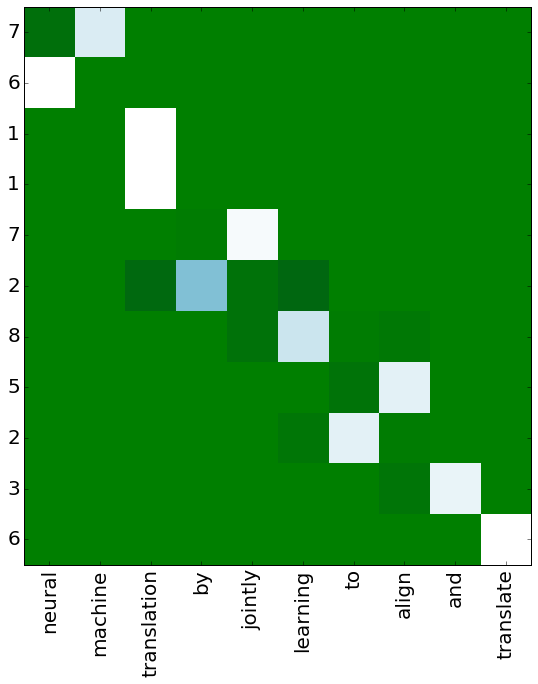

In [117]:
%matplotlib inline

import matplotlib.pylab as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
fig.canvas.draw()
ax.set_xticks(range(10))
ax.set_xticklabels(current_test_sequences[0].split(),rotation=90, fontsize=20)
ax.set_yticks(range(11))
ax.set_yticklabels([n for n in num_text], fontsize=20)
ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.ocean)
plt.show()